In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import copy
import scipy.io
from scipy.fftpack import fft, ifft, fftshift  #using the scipy version of the fft is better, since numpy will unnecessarily cast the data to a larger size

### Read in your image of the data, it should just have the graph, no axis, no text

In [33]:
name = "LEGO_capitol.png"
image_original = mpimg.imread(name) # Your file name goes here
max_price = 258.99                                           # The maxmimum price from Amazon
min_price = 76.22                                               # The minimum price from Amazon (the minimum price must have existed for about a week, or else the segmentation will not recover that data)
ndays = 2631                                                    # The number of days the dataset existed for, this is important for frequency analysis and the time axis labelling only

### View your image to make sure everything looks right

(-0.5, 1785.5, 797.5, -0.5)

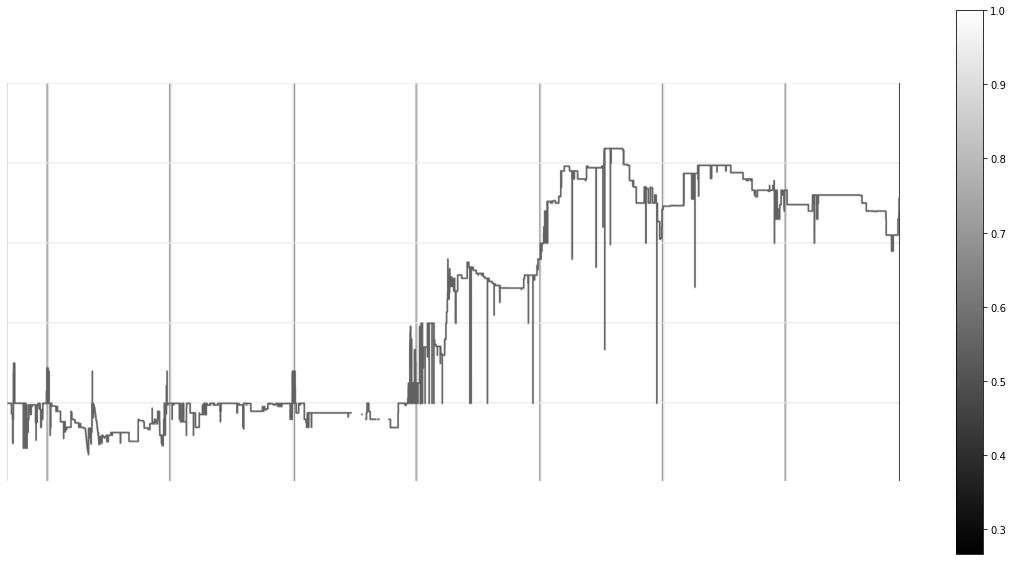

In [34]:
plt.figure(figsize=(20,10))
plt.imshow(image_original[:,:,0], cmap ='gray')
plt.colorbar()
plt.axis('off')

In [35]:
# Optional: View each of the channels of your png. For white background images the second channel (index 1) is fine.
# plt.figure(figsize=(20,30))
# plt.subplot(411)
# plt.imshow(image_original[:,:,0], cmap = 'gray')
# plt.axis('off')
# plt.subplot(412)
# plt.imshow(image_original[:,:,1], cmap = 'gray')
# plt.axis('off')
# plt.subplot(413)
# plt.imshow(image_original[:,:,2], cmap = 'gray')
# plt.axis('off')
# plt.subplot(414)
# plt.imshow(image_original[:,:,3], cmap = 'gray')
# plt.axis('off')

### Thresholding

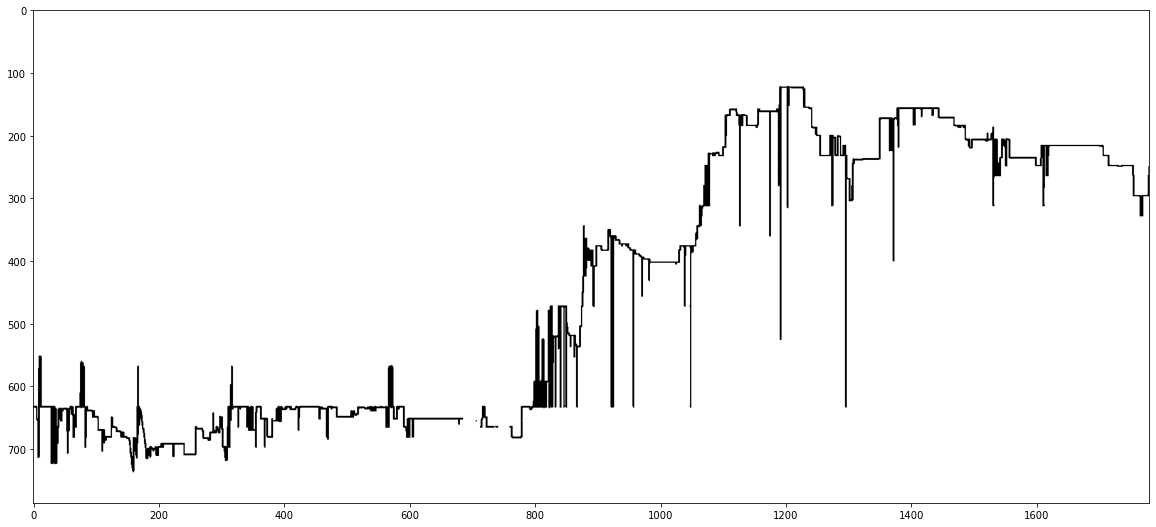

In [36]:
image_new = copy.deepcopy(image_original[:,:,1]) # Create a deepcopy so you can make edits to a true copy
image_new[image_new>0.65] = 1                           # Threshold all values greater than 0.65 to be 1 (setting everything that is not data to be background)
image_new[image_new<1] = 0                                # Set all data to be 0, so it can be picked out easier later
shape_,_ = image_new.shape
image_new = image_new[10:shape_-2,3:_-3] # Crop out the image if necessary. Sometimes borders get captured and skews the data
plt.figure(figsize=(20,20))
plt.imshow(image_new, cmap='gray')

### Produce Array Function
Iterates through the segmented image and picks out the value of the data. If it cannot find a value of data, it stores it as a negative so we can fix it later.

In [37]:
def produce_array(image):
    (rows, cols) = image.shape
    out_array = np.zeros(cols)
    for col in range(cols):                          # iterate through columns (so basically iterate through time)
        min_value = 2
        min_index = -1
        for row in range(rows):                     # iterate through the rows (prices) and find the highest price in the column (could instead find lowest price, medium, etc.)
            if image[row, col] < min_value:     
                min_value = image[row, col]
                min_index = row
        if min_index < 3:                               # if it didn't find anything or if it picked up an axis on the border (which is not data)
            out_array[col] = -100
        else:
            out_array[col] = rows-min_index
    return out_array

In [38]:
one_D_price = produce_array(image_new)  # run the function on the image, we now have an array, but it has problems. We will now fix them

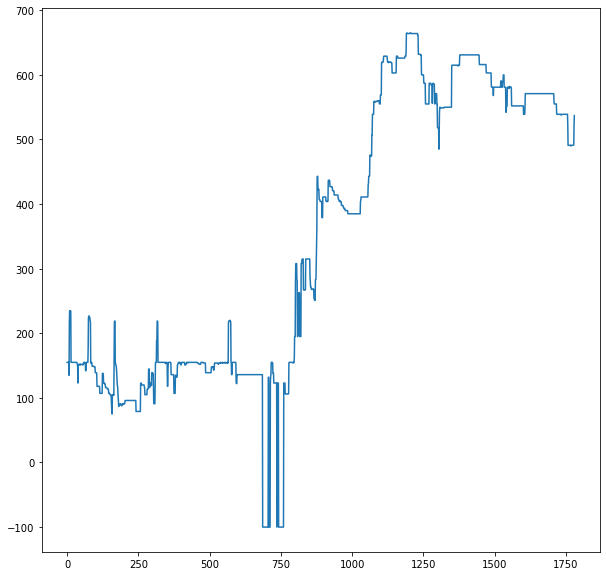

In [39]:
# Plot out the initial array. All negative values need to be fixed. We see that some minimums are missing, this is because of our image reading strategy.
# In a given column, there might be a vertical line of prices, we use the maximum price in this column.
plt.figure(figsize=(10,10))
plt.plot(one_D_price)

### Rectify Negatives Function
We have marked our array with negative values where the processing function was unable to find a price value. Either the axis has been picked up, or there was no data in the first place. We will now fix this by stitching together the data and assuming that for all negative values, it takes the value from the most recent valid time. In other words, if we dont know what the price is on Tuesday, we assume it kept the same price as Monday. Again, this is just one strategy to fix broken data.

In [40]:
def rectify_negatives(in_array):
    length = len(in_array)
    out_array = np.zeros(length)
    j = 0
    for i in range(length):
        if in_array[i]<0 and i>0:
            in_array[i] = in_array[i-1]
            out_array[i-j] = in_array[i-1]
        elif in_array[i]>0:
            out_array[i-j] = in_array[i]
        elif in_array[i]<0 and i==j: # this special case is if the signal is invalid to begin with, in which case we just shorten the output
            j = j+1
    out_array = out_array[:(length-j)]
    return out_array

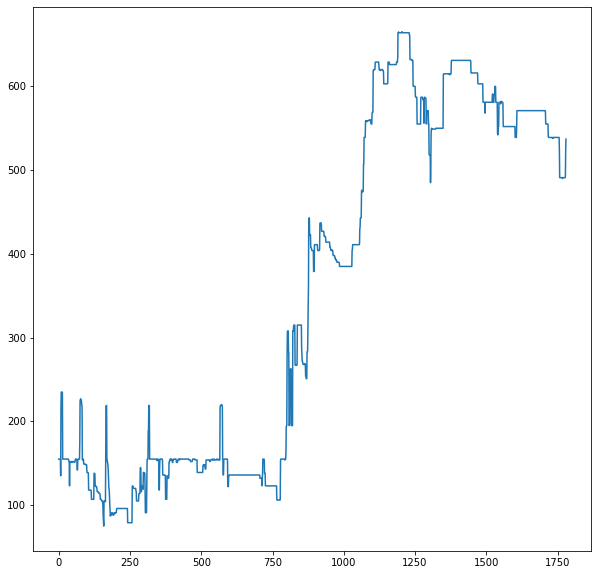

In [41]:
# Fix the array
rectified_arr = rectify_negatives(one_D_price)
plt.figure(figsize=(10,10))
plt.plot(rectified_arr)

### Rescale and Present Data

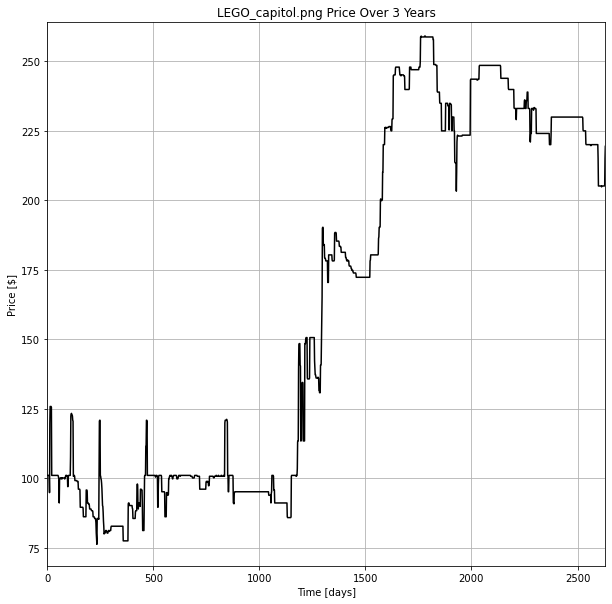

In [42]:
cols = rectified_arr.shape[0]
min_rectified_arr = np.min(rectified_arr)
rectified_arr_bs = rectified_arr-min_rectified_arr
max_rectified_arr_bs = np.max(rectified_arr_bs)
time = np.linspace(0,ndays, cols)

rectified_arr_rescaled = min_price + (max_price-min_price)*rectified_arr_bs/max_rectified_arr_bs  # rescale

# np.save(name+".npy", np.array([time, rectified_arr_rescaled])) # save your data in an array

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.plot(time, rectified_arr_rescaled, c = 'black')
plt.title(name+' Price Over 3 Years')
plt.xlabel('Time [days]')
plt.ylabel('Price [$]')
plt.ylim([min_price-7.73, max_price+5])
plt.xlim([0, time[cols-1]])
plt.grid('on')
# ax.set_aspect(10) #customize this if you would like
# plt.savefig('post_processed_data_plot.png', dpi = 600) #save your figure if you would like

# Pre-Analyze the Data

In [43]:
# obtain the Fourier Transform
FT = fft(rectified_arr_rescaled)/cols

In [44]:
# maximum frequency is derived from the distance between two immediate samples, i.e. 1/time_arr[1]. The minimum frequency is 1/time_arr[end]
# we know that the total time is 1257 days, and that there are cols entries. 
smallest_time = ndays/cols
largest_freq = 1/smallest_time
largest_time = ndays
smallest_freq = 1/largest_time
frequencies = np.linspace(0,largest_freq, cols)

### Plot the Fourier Transform Magnitude

Text(0.5, 0, 'Frequency [1/days]')

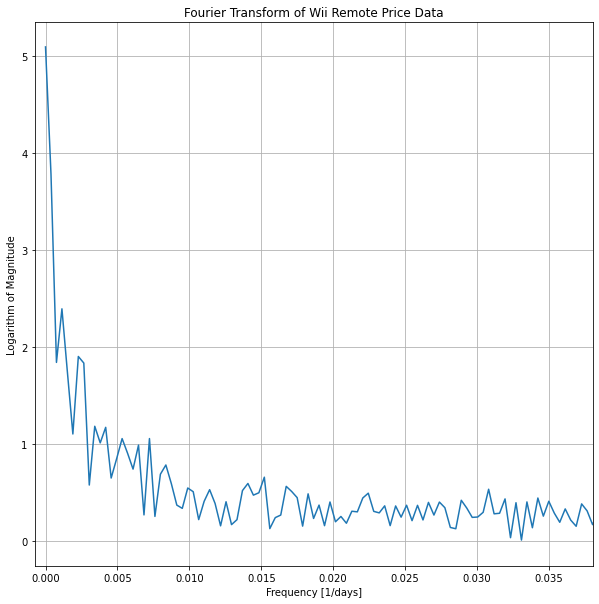

In [45]:
fig = plt.figure(figsize=(10,10),  facecolor = 'white')
ax = fig.add_subplot(111)
plt.plot(frequencies, np.log(np.abs(FT)+1))
plt.grid('on')
plt.xlim([-frequencies[2],frequencies[100]])            # only looking at some low frequencies right now
plt.title('Fourier Transform of Wii Remote Price Data')
plt.ylabel('Logarithm of Magnitude')
plt.xlabel('Frequency [1/days]')

### Predictive Potential
The behavior of perfect markets is random, and ruled by Brownian noise. Brownian noise drops of as 1/f^2 in Fourier space, and on a log-log scale, it is a line with slope -2. If our power spectrum (mag(FFT)**2) deviates from this slope, then it is not entirely random and has predictive potential.

/tmp/ipykernel_304/2152471991.py:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(frequencies, 0.0002/(frequencies**2))


Text(0, 0.5, 'Logarithm of Magnitude')

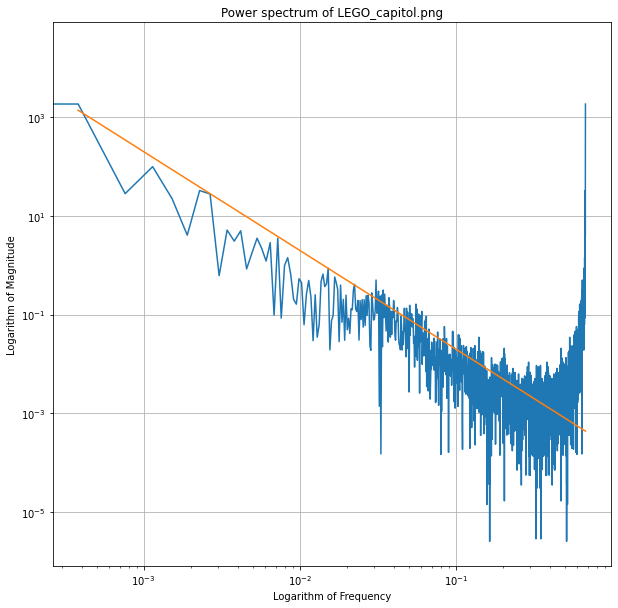

In [52]:
fig = plt.figure(figsize=(10,10),  facecolor = 'white')
ax = fig.add_subplot(111)
plt.loglog(frequencies, np.abs(FT)**2)
plt.loglog(frequencies, 0.0002/(frequencies**2))  #this line can be modified to shift the Brownian line up and down. Its intercept is arbitrary, its slope is important
plt.grid('on')
plt.title("Power spectrum of "+ name)
plt.xlabel("Logarithm of Frequency")
plt.ylabel("Logarithm of Magnitude")
# plt.savefig(name+'_predictive_potential.png') # save figure if you would like

# Fourier transform filtering
We low pass filter our FT (which is periodic, so this entails the collection of the beginning and end components of the FT array). This is in the hopes that a continuous dataset can be predicted with more ease.

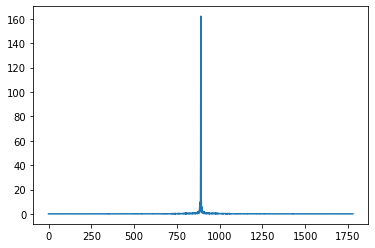

In [47]:
FT_filtered = np.zeros(cols).astype(complex)
filter_f = 60
shifted_FT = fftshift(FT)
middle_f = cols/2
FT_filtered[int(middle_f-filter_f):int(middle_f+filter_f)] = shifted_FT[int(middle_f-filter_f):int(middle_f+filter_f)]
signal_low_pass_filtered = ifft(fftshift(FT_filtered))
plt.plot(np.abs(shifted_FT))

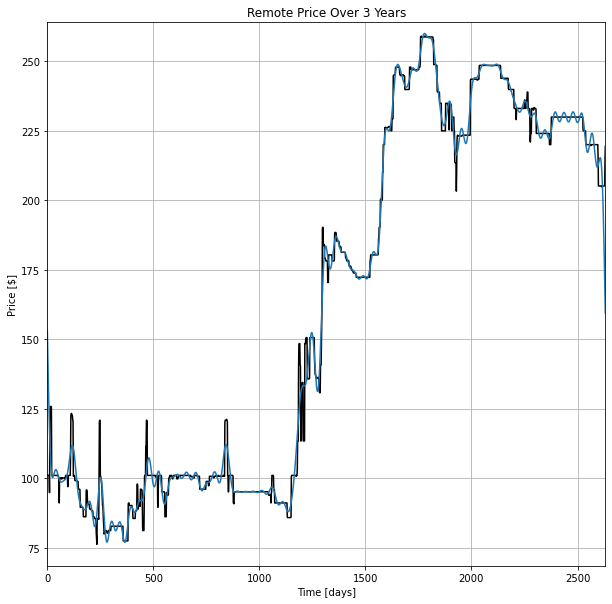

In [48]:
plt.figure(figsize=(10,10),  facecolor = 'white')

ax1 = fig.add_subplot(111)
plt.plot(time, rectified_arr_rescaled, c = 'black')
plt.title('Remote Price Over 3 Years')
plt.xlabel('Time [days]')
plt.ylabel('Price [$]')
plt.ylim([min_price-7.73, max_price+5])
plt.xlim([0, time[cols-1]])
plt.grid('on')

plt.plot(time, np.abs(signal_low_pass_filtered*cols))
plt.title('Remote Price Over 3 Years')
plt.xlabel('Time [days]')
plt.ylabel('Price [$]')
plt.ylim([min_price-7.73, max_price+5])
plt.grid('on')

# np.save(name+"_filtered.npy", np.abs(signal_low_pass_filtered*cols)) # save the filtered array if you would like